## Chapter 09. 비지도 학습


### 9.1 2차원 입력 데이터 

- (6장 클래스 분류에서 사용한) 2차원 입력 데이터 X를 사용하여, 입력 데이터가 비슷한 것끼리 Class로 나누는 문제
- 데이터의 분포의 모양(Cluster)을 찾아서, 동일한 클러스터에 속하는 데이터 점에는 같은 클래스(Label)를, 다른 클러스터에 속하는 점에는 다른 클래스(Label)를 구함
- 동일한 클러스터에 속하는 데이터 점은 "닮았다" / 다른 클러스터에 속하는 데이터 점은 "닮지 않았다"라고 정의할 수 있음

#### 추가 설명

(1) 군집과 분류의 의미 차이
- 분류와 마찬가지로 각 샘플은 하나의 그룹을 할당
- 분류는 지도 학습(y), 군집은 비지도 학습(y가 없음)

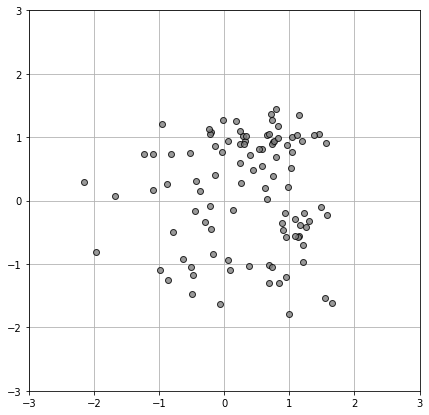

In [1]:
# 필요 모듈 불러오기
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
%matplotlib inline

# 데이터 생성 
N, K= 100, 3                                      # 데이터 개수, 차원 설정 
T3 = np.zeros((N, 3), dtype=np.uint8)             # 3차원 클래스 데이터 정의(사용하지는 않음 )
X = np.zeros((N, 2))                              # 2차원 입력 데이터 정의
X_range0, X_range1 = [-3, 3],  [-3, 3]            # 입력 데이터 범위 지정

X_col = ['cornflowerblue', 'black', 'white']      # 데이터별 구분색 지정
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])  # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])    # 분포의 분산
Pi = np.array([0.4, 0.8, 1])                      # 누적 확률


for n in range(N):
    wk = np.random.rand()                         # random 데이터 생성(0 ~ 1 사이)
    for k in range(K):                           # 해당 데이터의 범위가 누적 확률에 따라서 클래스 정의(크러스터링)
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):                           # 입력 데이터(x0, x1) 각각 클래스(클러스터링)의 분포와 중심과 분산에 맞게 값 재지정
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])


# 데이터 시각화 함수
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none', marker='o', markersize=6, markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 최종 정의
plt.figure(1, figsize=(7, 7))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0, X_range1=X_range1) # 데이터 저장 

#### 그림 설명 
- 데이터 분포를 크게 3가지로 나눌 수 있음

### 9.2 K-means 기법

#### 9.2.1 K-means 기법의 개요

- Hypterparameter: K(분할할 Clustring의 수)
- 변수: $u$ (클러스터 중심 벡터, 중심 위치) /  $R$(클래스 지시 변수, 각 데이터 점이 어떤 클러스터의 속하는지 알려주는 변수)

1) Step 0: Clustring 중심 벡터 $u$ 적절한 값(초기값) 부여  
2) Step 1: 현시점의 $u$를 바탕으로, Class 지시 변수 $R$를 결정  
3) Step 2: 현시점의 $R$로 $u$  
4) step 3: step 1 ~ 2를 값이 변하지 않을 때까지 반복함  

#### 9.2.2 step 0: 변수의 준비와 초기화

1. k번째 클러스터링 중심 벡터 정의 및 초기화 
- 입력 차원이 2차원 => 클러스터링 중심도 2차원 벡터
- 중심 벡터는 알고리즘 최초의 적당한 초기값 설정
(예: $u_{0} = \begin{bmatrix} -2, 1\end{bmatrix}, u_{1} = \begin{bmatrix} -2, 0 \end{bmatrix}, u_{2} = \begin{bmatrix} -2, -1 \end{bmatrix}$)

<br>
$$ u_{k}  =  \begin{bmatrix} u_{ko}, u_{k1} \end{bmatrix}  (k = 0, 1, 2)$$

<br>

2. 클래스 지시 변수($R$) 정의
- 각 데이터가 어느 클래스에 속해 있는지 1-of-K 부호화(one-hot-encoding) 나타낸 행렬

$$ r_{nk}= \begin{cases} 1 & 데이터 n이 k에 속하는 경우 \\  0 & 데이터 n이 k에 속하지 않는 경우   \end{cases}$$

<br>
$$ R = \begin{bmatrix} r_{00} & r_{01} & r_{02} \\ r_{10} & r_{11} & r_{12} \\  \vdots & \vdots & \vdots \\ r_{n-1, 0} & r_{n-1,1} & r_{n-1,2} \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1  \\  \vdots & \vdots & \vdots \\ 1 & 0 & 0\end{bmatrix} $$

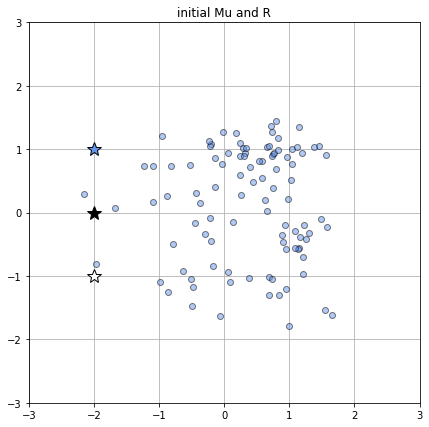

In [2]:
## step0: Clustring 변수 초기화 및 설정
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])                        # 중심 벡터 초기값 설정
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # 클래스 지시 변수 초기화

# clustring 변수 시각화
def show_prm(x, r, mu, col):
    
    ## class별 데이터 시각화
    for k in range(K):
        ## 데이터 분포의 묘사(각 클러스터에 해당하는 데이터 추출 시각화/ 색깔: clustring 지시 변수)
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1], marker='o', markerfacecolor=X_col[k], markeredgecolor='k', 
                 markersize=6, alpha=0.5, linestyle='none')
        
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',  markerfacecolor=X_col[k], markersize=15, markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)

## 시각화
plt.figure(figsize=(7, 7))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

#### 시각화 결과
- 모든 데이터가 클래스 0에 속하도록 $R$을 초기화하였기에 시각화에서 동일한 색상이 띔

#### 9.2.3 step 1: $R$ 의 갱신
- 갱신 원칙: 데이터 점을 (각 클러스터 중) 가장 중심이 가까운 클러스터에 넣음

<br>
1. 데이터 $ X = (x_{no}, x_{n1})$과 각 클러스터의 중심  $u_{k}$ 까지의 제곱 거리를 계산
<br>  
- 거리 자체가 중요한 것이 아니라, 데이터 점에서 가장 가까운 클러스터를 알고자 함

$$ \begin{vmatrix} x_{n} - u_{n} \end{vmatrix}^2 = (x_{n0} - u_{k0})^2 + (x_{n1} - u_{k1})^2 $$ 

<br> 

2. 거리가 가장 가까운 클래스를 그 데이터의 소속 클래스(클러스터)로 한다. 

$$ r_{nk}= \begin{cases} 1 & k에서 가장 가까운 클러스터 \\  0  \end{cases}$$

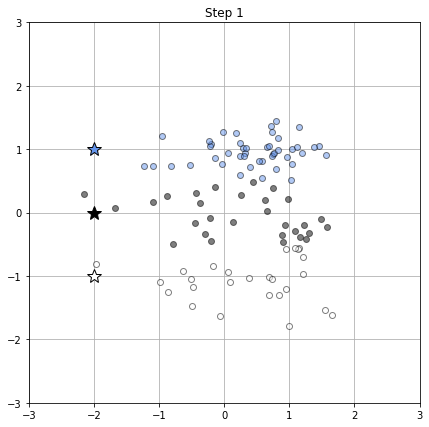

In [3]:
# Step 1: 현재 U를 기준으로 R을 결정
def step1_kmeans(x0, x1, mu):
    N = len(x0)               # 데이터 개수 
    r = np.zeros((N, K))      # 갱신할 지시 변수 array 생성
    
    ## 각 데이터별로 진행
    for n in range(N):
        wk = np.zeros(K)      # 데이터별 clustring의 거리를 저장할 변수 array 생성
        
        ## 해당 데이터를 각각의 Clustring mu를 중심으로 거리 계산 진행
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2 # 거리 계산: 유클리드 거리 
        r[n, np.argmin(wk)] = 1                                    # 최소값(가장 가까운) 클러스터에 1 부여
    return r

# 시각화
plt.figure(figsize=(7, 7))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

#### 9.2.4 step 2: $u$ 의 갱신
- 갱신 원칙: 각 클래스에 속하는 데이터 점의 중심을 새로운 $u$로 정의

- cluster에 속하는 데이터의 평균(합을 취한 후 개수만큼 나눔)

$$ u_{k, 0} = {1 \over N_{k}} \sum_{n \in k} x_{no}  $$ 
$$ u_{k, 1} = {1 \over N_{k}} \sum_{n \in k} x_{n1}  $$

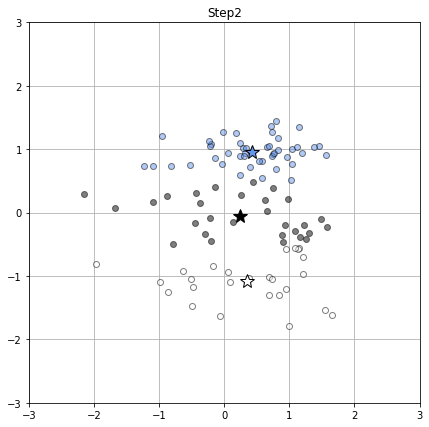

In [4]:
# Step 2: 각 클러스터 Mu 갱신 
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))   # 입력 차원: 2차원 => 갱신 mu 2차원
    
    ## cluster에 해당하는 데이터 추출해서 합계 구한 이후 -> 평균
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


## 시각화
plt.figure(figsize=(7, 7))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

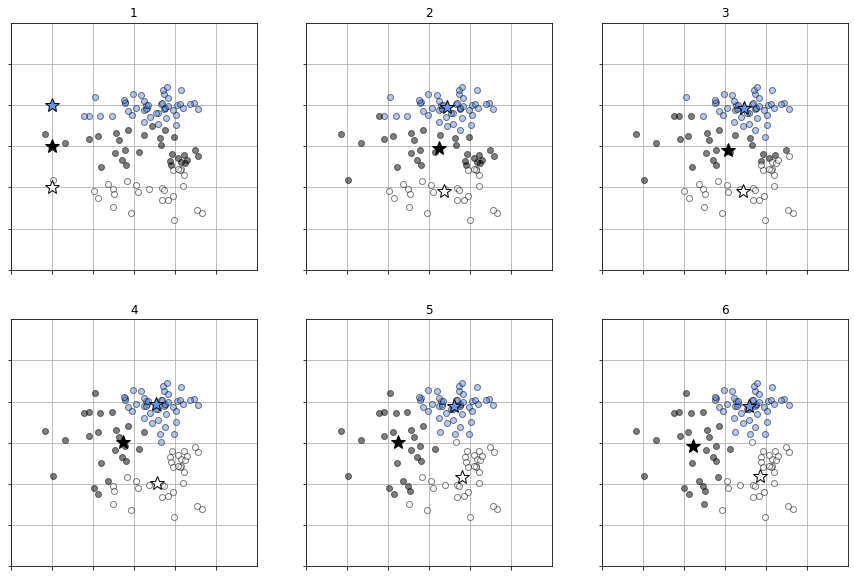

In [5]:
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # 초기 중심 벡터 정의 
max_it = 6 # 반복 횟수

## 6회 반복하여 K-Mean 변화 시각화

plt.figure(1, figsize=(15, 10))
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)          # step1: R 갱신
    show_prm(X, R, Mu, X_col)                       # R 갱신 결과 시각화
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "") # step2: mu 갱신
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

#### 갱신 결과
- $u$가 3개의 클러스터의 중심으로 이동하고, 각 클러스터마다 다른 Label이 할당하는 것을 확인
- 반복이 진행되더라도 특정 횟수(여기서는 6회) 이후에는 $R$과 $u$는 변하지 않음

#### 9.2.5 왜곡 척도
- k-means 기법(넓은 범위에서의 비지도 학습)의 오차함수/ 학습이 진행됨에 따라 감소하는 목적 함수  
    => 왜곡 척도: 데이터 점과 (해당) 클러스터의 중심과의 제곱 거리를 합한것 
   
<br>

- 왜곡 척도 표현식
$$ J =  \sum_{n \in 0_{cluster}} \begin{vmatrix} x_{n} - u_{0} \end{vmatrix}^2 + \sum_{n \in 1_{cluster}} \begin{vmatrix} x_{n} - u_{1} \end{vmatrix}^2  + \sum_{n \in 2_{cluster}} \begin{vmatrix} x_{n} - u_{2} \end{vmatrix}^2 $$ 

<br>

- 위의 식에서 덧셈 부분을 sigma로 변형
$$ J = \sum_{k = 0}^2 \sum_{n \in k_{cluster}}  \begin{vmatrix} x_{n} - u_{k} \end{vmatrix}^2 $$

<br>

- $r_{nk}$: 데이터 n이 속한 cluster 에만 1 아닌경우 0

$$ J = \sum_{n=0}^{N-1} \sum_{k=0}^{k-1} r_{nk} \begin{vmatrix} x_{n} - u_{k} \end{vmatrix}^2 $$

In [6]:
## 왜곡 척도 함수
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원 제한
    
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2)
    return J


# Mu와 R을 초기화 한 상황에서 왜곡척도 함수 계산(test)
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])                        # Mu 초기화
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # R 초기화 
distortion_measure(X[:, 0], X[:, 1], R, Mu)                         # 계산

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


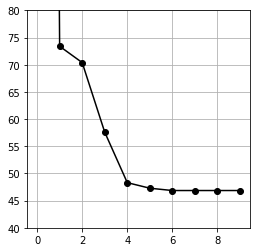

In [7]:
## n번 반복하며 k-means를 갱신하며 변화하는 왜곡 척도 값

## 필요 변수 정의
N, K=X.shape[0], 3                          # 데이터 개수 & 차원 결정
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # mu 초기값 설정
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # R 초기값 설정(모든 data의 cluster 0에 소속)
max_it, it = 10, 0 
DM = np.zeros(max_it)                       # 왜곡 척도의 계산 결과 array 생성

## k-means 적용
for it in range(0, max_it): 
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)               # R 갱신(step 01)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)               # mu 갱신(step 02)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

#### 결과 해석
- step 진행할수록 왜곡 척도는 감소 / but 어느정도 step(6회째) 왜곡 척도는 수렴($u$,$R$의 값이 변하지 않음)

#### 결론
- k-means의 기법으로 얻을 수 있는 해는 초기값의 의존이 있음(최초의 정의한 $u$ 할당에 따라 달라짐)
- 본 내용에서는 $u$를 설정한 이후 -> $R$와 $u$를 갱신했다면 / $R$ 먼저 설정해도 됨 

### 9.3 가우시안 혼합 모델 

#### 9.3.1 확률적 클러스터링 
- k-means: 데이터 점을 반드시 클러스터에 할당(클러스터 중심에 있는 데이터, 클러스터 끝에 있는 데이터가 동일하게 할당)
- 모호성(데이터 A는 확실하게 cluster 0에 속하지만 데이터 B는 cluster 0과 1 사이의 속함)을 포함해 수치화 하는 방법: 확률적 클러스터링
- 예시:

$$ r_{A}  =  \begin{bmatrix} r_{Ao}, r_{A1}, r_{A2} \end{bmatrix} =  \begin{bmatrix} 0.9, 0.1, 0.0 \end{bmatrix} $$


#### 예시 
- 2차원 입력 데이터를 곤충의 질량($x_{0}$)과 크기($x_{1}$)로 가정: 곤충의 변종에 따라서 질량과 크기에 결정 

<br>

(1) 잠재 변수(숨은 변수)
- (관찰은 하지 못했지만) 데이터에 영향을 준 변수(관찰할 수 없는 변수)
- k-means의 $R$과 거희 같음 / "어떤 클래스에 속하고 있는가"
- 표시: 

$$ z_{n}  =  \begin{bmatrix} z_{no}, z_{n1}, z_{n2} \end{bmatrix} $$

<br>

(2) 부담률
- 잠재 변수의 추정치, 확률적인 추정값(확률의 개념임으로 0 ~ 1사이의 값
- "어떤 클래스에 얼마나 기여하고 있는가" / 관찰할 수 없는 잠재 변수(Z)의 추정치가 부담률(r)
- 표시:

$$ Y_{nk}  = P(z_{zk} = 1 | x_{n}) $$


#### 9.3.2 가우시안 혼합모델: 2차원 가우스 함수 여러개를 함친 모델

$$ p(x) = \sum_{k=0}^{K-1} \pi_{k} N(x|u_{k}, \sum_{k})  $$

- 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 K개 겹친 분포
- $u_{k}$: 각 가우스 분포의 중심을 나타내는 중심 벡터
- $\sum_{k}$: 각 가우스 분포의 퍼짐을 나타내는 공분산 행렬
- $\pi$: 각 가우스 분포의 크기의 비율 (비율임으로 0과 1사이의 값, 전체 비율의 합 =1)

#### 참고사항 2차원 가우스 함수
$$ y = a * exp({1 \over 2}(x-u)^T (\sum)^-1(x-u)) $$ 

- x = $\begin{bmatrix} x_0, x_1 \end{bmatrix}$ (입력 vector)
- u = $\begin{bmatrix} u_0, u_1 \end{bmatrix}$ (평균 vector / 분포 중심)
- $(\sum)$ =  $\begin{bmatrix} \sigma_0, \sigma_2 \\ \sigma_2, \sigma_1 \end{bmatrix}$ (공분산 행렬, 확률변수의 상관정도)  
$\sigma_0$과 $\sigma_1$은 각각의 $x_0$와 $x_1$ 방향의 분포  
$\sigma_2$는 $x_0$와 $x_1$ 상관관계의 대응


#### 가우스 함수 
- x: N * D 데이터 행렬
- mu: D인 중심 벡터
- sigma: D * D 공분산 행렬

In [50]:
%reset               # 메모리 초기화

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  메모리, please run `%reset?` for details
Don't know how to reset  초기화, please run `%reset?` for details


In [51]:
# 데이터 불러오기
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0, X_range1 = wk['X_range0'], wk['X_range1']

## 가우스 함수 정의
def gauss(x, mu, sigma):
    N, D = x.shape                            # N: 데이터 개수 / D: 차원
    c1 = 1 / (2 * np.pi) ** (D / 2)           # 알파부분1: '데이터 차원 / 2'만큼 제곱.
    c2 = 1 / (np.linalg.det(sigma) ** (1 / 2))# 알파부분2: 공분산행렬의 행렬식 역수 값에 '1/2'만큼 제곱
    inv_sigma = np.linalg.inv(sigma)          # 공분산 행렬의 역행렬 구함
    c3 = x - mu                               # x-u 벡터를 구함
    c4 = np.dot(c3, inv_sigma)                # 각 변수의 2차식 형태로 만들기 위한 전치
    c5 = np.zeros(N)                          # 알파부분을 합치기 위한 정의
    for d in range(D):                     
        c5 = c5 + c4[:, d] * c3[:, d]         # 알파 정의 
    
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

## 데이터를 가지고 실험(test)
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [53]:
## 가우시안 혼합 모델 정의 
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape               
    K = len(pi)                # 혼합계수 개수 
    p = np.zeros(N)            # 각 class(cluster number)의 확률 값 
    
    ## 
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])  # 혼합계수 * gauss 모델 곱한 것들의 결과를 통해 확률 값 추론
    return p

x = np.array([[1, 2], [2, 2], [3, 4]])  # 입력 3개 데이터 2차원 
pi = np.array([0.3, 0.7])               # 혼합계수 2차원 -> 가우스 혼합모델의 개수 
mu = np.array([[1, 1], [2, 2]])         # 데이터 차원이 2차원 -> 중심 벡터 2차원 
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]]) # 
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


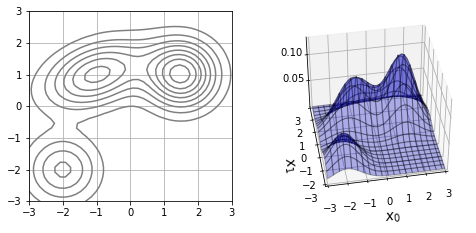

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

## 혼합 가우스 함수 등고선 시각화 함수 
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40                                         # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)  # 2차원 x0 입력 데이터 생성(해상도)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)  # 2차원 x1 입력 데이터 생성(해상도)
    xx0, xx1 = np.meshgrid(x0, x1)                  # grid 생성
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # xx0 와 xx0를 vector로 변환 후 결합
    f = mixgauss(x, pi, mu, sigma)                                          # 정의한 변수에 따른 gauss 생성
    f = f.reshape(xn, xn)                                                   # 2차원 형식 변환
    f = f.T                                                                 # 전치: 순서의 변화를 맞추기 위함()
    plt.contour(x0, x1, f, 10, colors='gray')                               # 열의 변화가 xx1의 변화 행의 변화 xx0의 변화


# 혼합 가우스 3D 시각화 함수
def show3d_mixgauss(ax, pi, mu, sigma):              # 위와 상동한 내용(마지막 코드만 달라짐)
    xn = 40 
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3, color='blue', edgecolor='black')
    
# 함수 정의 필요한 변수 정의 
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array( [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

# 시각화 
Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

#### 9.3.3 EM 알고리즘 개요
- 가우시안 혼함모델에 데이터 fitting -> 부담률을 구하는 방법(k-means 확장하는 방법)

1) Step 0: $u$, $\pi$, $\sum$ 적절한 값(초기값) 부여  
2) Step 1: 현 시점 $u$, $\pi$, $\sum$ 으로 부담률(r) 구함 => E step   
3) Step 2: 현 시점 부담률(r)로 $u$, $\pi$, $\sum$을 갱신  => M step   
4) step 3: step 1 ~ 2를 값이 변하지 않을 때까지 반복함  


- k-means와 방식과 매우 유사
   
#### 차이점
(1) k-means 기법: 각 클러스터를 중심 벡터($u$)로 정의 vs 가우시안 혼합모델 기법: 중심벡터($u$)과 공분산 행렬($\sum$)에 의해 분포 정도 정의  
(2) k-means 출력: 1-of-k 부호화($R$) vs 가우시안 혼합모델 출력: 각 클래스의 확률에 대응하는 부담률($r$)  
(3) 혼합계수($\pi$)를 사용: 클러스터의 크기 차이 정의

#### 9.3.4 Step 0: 변수 준비 및 초기화

- 초기값으로 할당한 중심 벡터가 인접하여 가우스 함수가 겹쳐 세로로 긴 산과 같은 분포로 표현

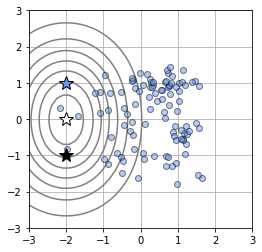

In [57]:
## 초기갑 설정
N = X.shape[0]                                                           # 데이터 개수
K = 3                                                                    # 생성하는 가우스 모델 개수
Pi = np.array([0.33, 0.33, 0.34])                                        # 초기 혼합계수(동일한 비율)
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])                              # 초기 중심 벡터
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]) # 초기 가우스 행렬 값 정의
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]                         # 잠재 변수 정의 

X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])                 # 데이터 시각화를 위한 값 지정(색깔)


# 데이터 시각화 함수 
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma) # 초기 변수(중심벡터, 가우스 행렬)에 따른 등고선 시각화
    
    ## 데이터(x)의 분포 시각화
    for n in range(N):
        col=gamma[n,0] * X_col[0] + gamma[n,1] * X_col[1] + gamma[n,2] * X_col[2] # x 데이터의 시각화 색깔
        plt.plot(x[n, 0], x[n, 1], 'o', color=tuple(col), markeredgecolor='black', markersize=6, alpha=0.5)
        
    ## 중심위치 시각화(별) 
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*', markerfacecolor=tuple(X_col[k]), markersize=15, markeredgecolor='k', markeredgewidth=1)
        
        
    plt.grid(True)

# 시각화(메인)
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

#### 9.3.5 Step 1(E step): $r$ 갱신

- 각 데이터 점의 부담률을 계산 / "가우스 함수의 값이 높아질수록 부담률도 높아진다"는 직관적 갱신 방법 활용
- 수식
$$ r_{nk} = {\pi_{k} N \over \sum_{k'}^K N} = {\pi_{k} N(x_{n}|u_{k}, \sum_{k})\over \sum_{k'}^K N(x_{n}|u_{k'}, \sum_{k'})} $$

<br>  
1. 데이터 점($n$)에서 각 가우스 함수의 높이($a_{k} = \pi N(x_{n}|u_{k}, \sum_{k})$)를 구함 <br>
2. 각각의 값들을 규격화($r_{nk}$)하기 위해서 총합($\sum_{k'}^k a_{k'}$) 나눔   
     => 각각의 규격화된 값은 0 ~ 1 사이의 값 + k개 합을 취하면 1값이 나옴
     
#### 의미적으로 정리
- 현재 중심, 분산(공분산) 그리고 혼합계수를 활용해서 각각의 점들의 확률적 통계를 갱신

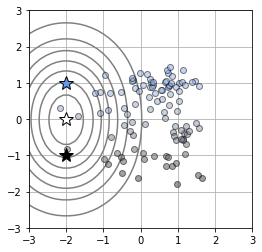

In [58]:
# E step: Gammaa를 갱신
def e_step_mixgauss(x, pi, mu, sigma):
    ## 필요 변수 정의(데이터개수, 차원, 가우스 모델 개수, 이들의 확률 값을 저장할 array)
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))   # y(각각의 cluster의 확률): 데이터 개수 * 부담률 개수 
    
    ## 01. 데이터별 해당 cluster에 소속될 확률 정의(데이터별 가우스 함수의 값을 계산) / 혼합 계수 이전
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # N * K 
    gamma = np.zeros((N, K))
    
    ## 02. 각각의 값들을 규격화 (02-1: 가우스 함수의 혼합 계수를 곱한 이후 -> 총합으로 나눠서 규격화)
    for n in range(N):
        wk = np.zeros(K)               # 데이터 점의 각우스 함수 높이를 저장할 array
        for k in range(K):
            wk[k] = pi[k] * y[n, k]    # 가우스 함수의 각각의 비율인 혼합계수를 곱함
        gamma[n, :] = wk / np.sum(wk)  # 규격화 진행
    return gamma


# 시각화(메인)
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

#### 9.3.6. Step 2(M Step) $u$, $\pi$,  $\sum$ 갱신

1.각 클러스터에 포함된 데이터의 실질적인 수 $N_{k}$를 구함

$$N_{k} = \sum_{n=0}^{N-1} r_{nk}$$

<br>
2. 혼합률($\pi_{k}$)를 갱신
- 혼합률: 전체에 대한 클러스터 내 수의 비율(N:전체 데이터 수)

$$ \pi_{k}^{new} = {N_{k} \over N} $$

<br>
3 중심 벡터($u_{k})$를 갱신
- 입력 데이터 * 부담률의 가중치를 더해서 데이터 평균을 구함
- K-means(step 02_에더 클러스터의 데이터 평균을 구하는 것과 대응됨

$$ u_{k}^{new} = {1 \over N_{k}} \sum_{n=1}^{N-1} r_{nk}x_{n}  $$

<br>
4. 가우스 공분산 행렬 갱신
- 주의할점: 갱신식에서는 갱신된 중심 벡터를 사용
- 클러스터에 부담률의 가중치를 더한 데이터 공분산 행렬

$$ \sum_{k}^{new} = {1 \over N_{k}} \sum_{n=1}^{N-1} r_{nk}(x_{n} - u_{k}^{new})^T(x_{n} - u_{k}^{new}) $$

#### 의미적으로 정리
- 현재 확률적 통계를 기반으로해서 각각의 클러스터의 평균, 분산, 혼합계수를 갱신  
(1. 현 시점의 부담률을 기반으로 소속된 클러스터 데이터 수를 구함 -> 2. 데이터 수에 따라서 혼합률[각 클러스터별 데이터의 비율] -> 3. 평균 벡터와 공분한 행렬 갱신)

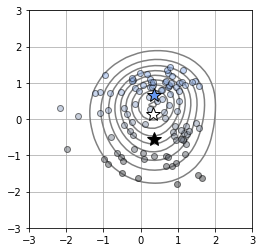

In [59]:
def m_step_mixgauss(x, gamma):
    
    ## 필요 요소 정의(N: 데이터 수, K: class[부담률], D: 입력 차원)
    N, D = x.shape
    N, K = gamma.shape
    
    ## 1.혼합률 갱신(각 cluster의 별 소속 개수[gamma의 최대값]의 데이터로 나눔)
    pi = np.sum(gamma, axis=0) / N
    
    ## 2.mu을 갱신
    mu = np.zeros((K, D))  # mu를 갱신할 array 생성(가우스 혼합모델 개수 * 차원): mu 사용은 가우스 혼합모델 만큼 사용
    for k in range(K):
        for d in range(D): # gamma(부담률): N * K / x: N *D, 부담률 * 입력 데이터 / 전체 합
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
            
    ## 3.sigma를 갱신
    sigma = np.zeros((K, D, D)) # 왜 3차원? : Kㅐ개의 가우스 함수의 공분산 행렬(D * D 차원)을 한꺼번에 진행
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]                                               # 1. 데이터 - 클러스터 중심 
            wk = wk[n, :, np.newaxis]                                       # 2. 차원을 확장(이유: sigma 정의 3차원)
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)# 3. 클러스터별 속한 데이터의 값들 더함
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])               # 4. 클러스터의 데이터 개수로 최종 구함
    return pi, mu, sigma


# 함수 호출 및 시각환(갱신 확인)
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

#### 시각화 결과
- 중심 벡터(별포)가 클러스터 중심으로 이동됨

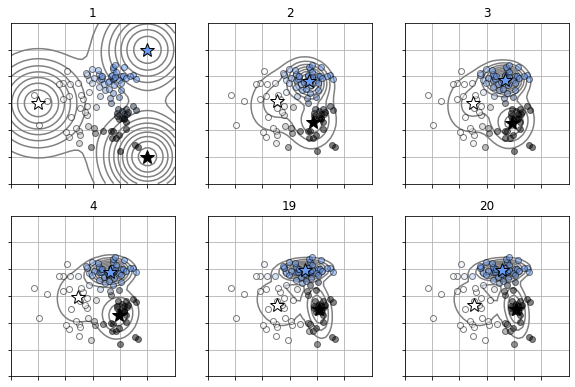

In [60]:
## 클러스터의 초기값 지정 
Pi = np.array([0.3, 0.3, 0.4])                                          # 초기 혼합률 
Mu = np.array([[2, 2], [-2, 0], [2, -2]])                               # 초기 중심 벡터
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])# 초기 공분산 행렬
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]                        # 초기 Gamma


# 시각화 진행
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수

i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)           # Step e: 부담률 갱신
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)      # 갱신된 결과 시각화
        plt.title("{0:d}".format(it + 1))               # 시각화 부가적인 요소(제목, x, y축 설정)
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)           # Step m: 중심벡터, 공분산 행렬, 혼합률 갱신 
plt.show()

#### 시각화 결과
- 20회를 반복하여 얻은 경과 표시(중심 벡터 초기값은 분포를 덮도록 진행

1. 중심 벡터(별)은 각 클러스터의 중심 부근으로 정착  
2. 데이터 점의 색: (파란색, 흰색, 검은색) 3개의 클러스터   
3. 클러스터의 경계 부근에서는 중간적인 색으로 데이터 표시(클러스터에 소속이 확률인 부담률로 표현)  
4. 클러스터의 결과는 (K-means와 유사) 매개 변수 초기값에 따라 달라짐 => 다양한 초기값을 사용 

#### 9.3.7 가능도: 가우시안 혼합 모델의 성능 평가 요소

#### 개관
- 가우시안 혼합모델 "데이터 분포 $p(x)$를 나타내는 모델" = "각 가우스 분포"가 다른 클러스터를 표현한 모델 
- EM 알고리즘: 입력 데이터 X이 분포에 맞게 매개 변수를 갱신하는 알고리즘

#### 목적 함수: 가능도
- 입력 데이터를 가우시안 혼합모델에서 생성된 것으로 가정: X가 생성된 확률(가능도) 높도록 매개 변수 갱신

1. 모든 데이터 점 x가 모델에서 생성된 확률(SIGMA 부분: 가우스 모델 생성) / 확률 계산 곱셉으로 표현
$$ p(X|\pi, u, \sum) = 	\prod_{n=0}^{N-1} \sum_{k=0}^{K-1} \pi_{k}N(x_{n}|u_{k}, \sum_{k})$$ 

<br>
2. 로그를 취한 가능도(log 계산식 -> 곱셈을 덥셈으로 표현 가능
$$ \log p(X|\pi, u, \sum) = \sum_{n=0}^{N-1} \begin{Bmatrix} {\log \sum_{k=0}^{K-1} \pi_{k}N(x_{n}|u_{k}, \sum_{k})} \end{Bmatrix}$$ 

<br>
3. 로그 가능도를 최적화시키기 위해서(오차함수) 음수화 진행
$$ E(\pi, u, \sum) = - \log p(X|\pi, u, \sum) = -\sum_{n=0}^{N-1} \begin{Bmatrix} {\log \sum_{k=0}^{K-1} \pi_{k}N(x_{n}|u_{k}, \sum_{k})} \end{Bmatrix}$$ 

In [66]:
# 혼합 가우스 모델의 목적 함수 정의 
## 데이터 차원 정의: x(입력 데이터, N * D), pi(혼합률, K * 1), mu(중심베거, K, D), sigma(가우스 행렬, K * D * D)
## N = 데이터 개수, D: 입력 차원, K: cluster 수 
def nlh_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    
    ## 1. 데이터별 확률 분포 생성(가우스 함수)
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN(데이터별 가우스 확률 값 생성: 데이터 수 * 가우스)
    lh = 0                                           # 목적함수 초기값 설정(초기화)
    
    ## 2. 목적함수(오차 함수) 계산: 데이터별 계산 
    for n in range(N):
        wk = 0
        for k in range(K):                          # 
            wk = wk + pi[k] * y[n, k]               # 가우스 함수의 높이 계산
        lh = lh + np.log(wk)                        # 가우스 함수 확률 추정 목적 함수 계산 (로그를 취함)
    return -lh # 음의 로그 가능도 진행 lh: NxK (why:)

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


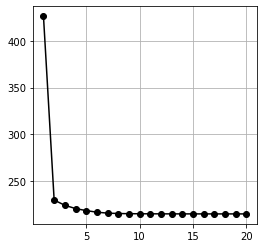

In [67]:
## 초기 값(중심벡터, 혼합률 등)설정
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20 # 반복 횟수
it = 0      # 학습 횟수 저장 변수
Err = np.zeros(max_it) # distortion 측정 결과 저장할 array

## max_it 횟수만큼 반복해 알고리즘 성능 측정
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma) #  EM 알고리즘 E step
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)     #  성능 측정
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma) #  EM 알골리즘 R step 


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()

#### 결과
- 음의 log 기능도는 step 10에서 수렴하는 것을 확인  
- 해당 목적 함수를 통해 1) 알고리즘 정상 작동 여부 2) 반복 계산 종료 조건에 사용 가능  

#### appendix